<a href="https://colab.research.google.com/github/sprihajha/dl-mini-project/blob/main/MiniProject_DL23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries and modules

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np

# Section 1: Data preparation

In [ ]:
# Define the data augmentation and normalization steps
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 dataset for training
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Load the CIFAR-10 dataset for testing
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12854609.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Section 2: Model definition

In [ ]:
# Define the BasicBlock used in the ResNet architecture
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer and batch normalization
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        # Second convolutional layer and batch normalization
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Define the shortcut connection (identity mapping or 1x1 convolution + batch normalization)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # Pass input through the first convolutional layer, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Pass output through the second convolutional layer and batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
        # Apply ReLU activation
        out = F.relu(out)
        return out

# Define the modified ResNet model
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 32

        # Initial convolutional layer and batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual layers
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Adaptive average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Pass input through the initial convolutional layer, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Pass output through residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Pass output through adaptive average pooling and flatten the tensor
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        # Pass the flattened tensor through the fully connected layer to obtain class probabilities
        out = self.fc(out)
        return out

# Helper function to create a modified ResNet model
def ModifiedResNet21():
    return ModifiedResNet(BasicBlock, [2, 2, 2, 2])

# Section 3: Model training setup

In [ ]:
# Set the device to use for training (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the device
model = ModifiedResNet21().to(device)

# Print the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")
print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, model.parameters()))))

# Set up the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Set up the training accuracy, test accuracy, training loss and test loss arrays
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

Number of parameters: 2797610
Total layers 21


# Section 4: Model training and testing

In [ ]:
# Define the training function for one epoch
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over the training data batches
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients of the model parameters
        optimizer.zero_grad()
        
        # Forward pass: compute the model's predictions
        outputs = model(inputs)
        
        # Compute the loss between predictions and targets
        loss = criterion(outputs, targets)
        
        # Backward pass: compute the gradients of the loss with respect to the model parameters
        loss.backward()
        
        # Update the model parameters using the computed gradients
        optimizer.step()

        # Update the running loss, total count, and correct count for accuracy calculation
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Print the training loss and accuracy for this epoch
    print(f"Epoch: {epoch+1}, Loss: {running_loss/(i+1)}, Train accuracy: {100*correct/total}")
    return running_loss / (i + 1), 100 * correct / total

# Define the testing function for one epoch
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    # Iterate over the test data batches
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass: compute the model's predictions
            outputs = model(inputs)
            
            # Compute the loss between predictions and targets
            loss = criterion(outputs, targets)

            # Update the test loss, total count, and correct count for accuracy calculation
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Print the test accuracy for this epoch
    print(f"Epoch: {epoch+1}, Test accuracy: {100*correct/total}")
    return test_loss / (batch_idx + 1), 100 * correct / total

# Set the number of epochs for training
num_epochs = 200

# Train and test the model for the specified number of epochs
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time of the epoch
    train_loss, train_acc = train(epoch)  # Train the model for one epoch and get the loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    end_time = time.time()  # Record the end time of the epoch
    elapsed_time = end_time - start_time  # Calculate the elapsed time

    # Print the elapsed time for this epoch
    print(f"Epoch: {epoch+1}, Time: {elapsed_time:.2f} seconds")

    test_loss, test_acc = test(epoch)  # Test the model for one epoch and get the loss and accuracy
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    scheduler.step()  # Update the learning rate scheduler

Epoch: 1, Loss: 1.7246524291038514, Train accuracy: 35.776
Epoch: 1, Time: 31.19 seconds
Epoch: 1, Test accuracy: 47.15
Epoch: 2, Loss: 1.2318493098020553, Train accuracy: 55.374
Epoch: 2, Time: 26.22 seconds
Epoch: 2, Test accuracy: 62.22
Epoch: 3, Loss: 0.9548319683074952, Train accuracy: 66.056
Epoch: 3, Time: 26.17 seconds
Epoch: 3, Test accuracy: 66.44
Epoch: 4, Loss: 0.7852327561378479, Train accuracy: 72.756
Epoch: 4, Time: 25.00 seconds
Epoch: 4, Test accuracy: 68.79
Epoch: 5, Loss: 0.6930433012247086, Train accuracy: 76.074
Epoch: 5, Time: 25.05 seconds
Epoch: 5, Test accuracy: 71.12
Epoch: 6, Loss: 0.6449546626210213, Train accuracy: 77.688
Epoch: 6, Time: 25.11 seconds
Epoch: 6, Test accuracy: 69.35
Epoch: 7, Loss: 0.609939282476902, Train accuracy: 78.932
Epoch: 7, Time: 25.32 seconds
Epoch: 7, Test accuracy: 73.5
Epoch: 8, Loss: 0.5802719206213951, Train accuracy: 79.826
Epoch: 8, Time: 26.73 seconds
Epoch: 8, Test accuracy: 75.56
Epoch: 9, Loss: 0.5639775426983833, Train 

# Section 4: Draw graphs

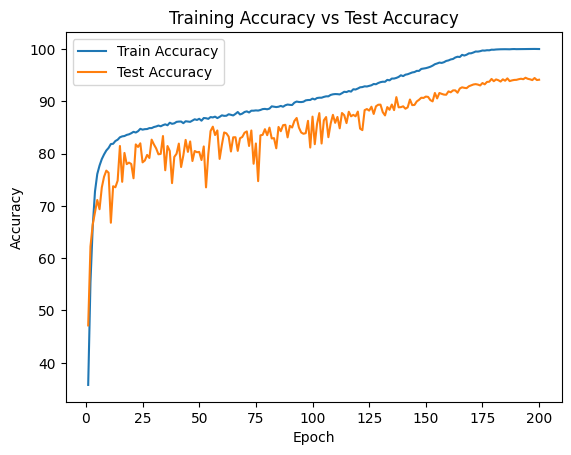

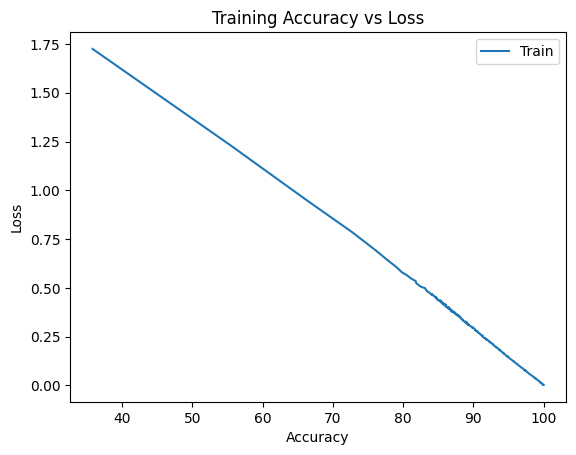

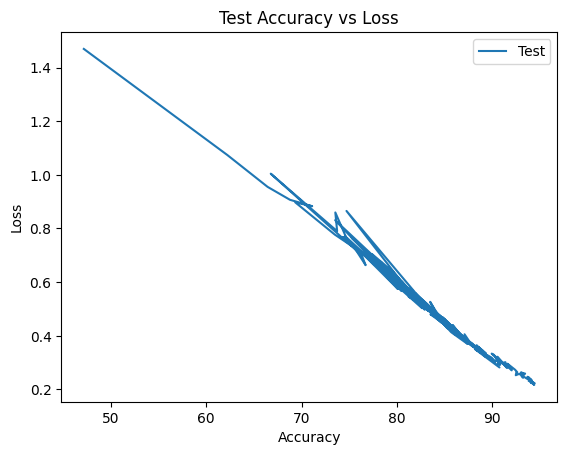

In [ ]:
# Plot the training accuracy vs test accuracy graph
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Test Accuracy")
plt.legend()
plt.show()

# Plot the training accuracy vs loss curve
plt.figure()
plt.plot(train_accuracies, train_losses, label="Train")
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.title("Training Accuracy vs Loss")
plt.legend()
plt.show()

# Plot the test accuracy vs loss curve
plt.figure()
plt.plot(test_accuracies, test_losses, label="Test")
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.title("Test Accuracy vs Loss")
plt.legend()
plt.show()

# Section 5: Display a test image with its label and predicted label

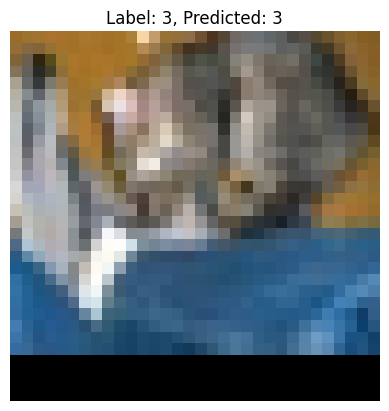

In [ ]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move a single test image and its label to the device
test_image = images[0].unsqueeze(0).to(device)
test_label = labels[0].unsqueeze(0).to(device)

# Get the model's prediction for the test image
with torch.no_grad():
    output = model(test_image)
    _, prediction = output.max(1)

# Move the test image, label, and prediction back to the CPU
test_image = test_image.cpu()
test_label = test_label.cpu()
prediction = prediction.cpu()

# Display the test image, label, and predicted label
plt.imshow(np.transpose(test_image[0] * 0.5 + 0.5, (1, 2, 0)))
plt.title(f"Label: {test_label.item()}, Predicted: {prediction.item()}")
plt.axis("off")
plt.show()